In [1]:
import math
import numpy as np

import librosa as lr
from librosa import display

import torch 
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import IPython

from parallel_wavenet import *
from wavenet_dataset import *
from constant_q_transform import *
from parallel_wavenet_trainer import *

In [28]:
model = WaveNetModel()
print("input_length:", model.input_length)
print("output length:", model.output_length)

input_length: 5116
output length: 1024


In [29]:
dataset = ParallelWavenetDataset('audio_clips', 
                                 item_length=model.input_length, 
                                 target_length=model.output_length, 
                                 test_stride=0)
print("dataset length:", len(dataset))

dataset length: 255


In [30]:
example, target = dataset[10]

In [31]:
IPython.display.Audio(example.squeeze(), rate=16000)

In [32]:
output = model(example)
output.shape

torch.Size([1024, 1])

In [33]:
target.shape

torch.Size([1, 1, 1024])

In [34]:
cqt_module = CQT(sr=16000, fmin=30, n_bins=250, bins_per_octave=32)

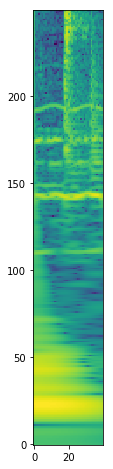

In [35]:
cqt = cqt_module(example)
scalogram = abs(cqt).squeeze()**2

fig = plt.figure(figsize=(8, 8))
plt.imshow(np.log(scalogram.detach()), origin='lower', aspect=1.)
plt.show()

In [36]:
scalogram.shape

torch.Size([250, 40])

In [37]:
conditioning_model_settings = conditioning_wavenet_default_settings
conditioning_wavenet_default_settings['conditioning_period'] = 128
conditioning_wavenet_default_settings['conditioning_channels'] = [250, 16]
conditioning_model = WaveNetModelWithConditioning(conditioning_model_settings)

In [38]:
cqt = cqt_module(example)
scalogram = abs(cqt).squeeze()**2
model_output = conditioning_model((example, scalogram.unsqueeze(0)))

In [39]:
model_output.shape

torch.Size([1024, 1])

In [40]:
output_signal = torch.cat([example[0, 0, :-conditioning_model.output_length], model_output[:, 0]], dim=0)

In [41]:
IPython.display.Audio(output_signal.detach(), rate=16000)

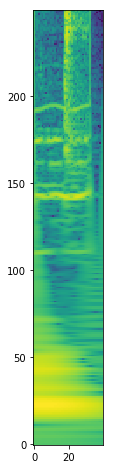

In [42]:
output_cqt = cqt_module(output_signal.view(1, 1, -1))
output_scalogram = abs(output_cqt).squeeze()**2

fig = plt.figure(figsize=(8, 8))
plt.imshow(np.log(output_scalogram.detach()), origin='lower', aspect=1.)
plt.show()

In [3]:
wavenet_settings = conditioning_wavenet_default_settings
wavenet_settings['conditioning_channels'] = [256, 16]
wavenet_settings['skip_channels'] = 32
test_model = WaveNetModelWithConditioning(wavenet_settings)
dataset = ParallelWavenetDataset('audio_clips',
                                 item_length=test_model.input_length,
                                 target_length=test_model.output_length,
                                 test_stride=0)
trainer = ParallelWavenetTrainer(test_model, dataset, CQT())
trainer.train(4, 1)

epoch 0
step 1 - loss: 9.714507102966309
step 2 - loss: 3.0075550079345703
step 3 - loss: 12.304705619812012
step 4 - loss: 6.954205513000488
step 5 - loss: 8.206954002380371
step 6 - loss: 5.016345977783203
step 7 - loss: 3.8030614852905273
step 8 - loss: 6.606476783752441
step 9 - loss: 2.5330982208251953
step 10 - loss: 3.248231887817383
step 11 - loss: 1.6899313926696777
step 12 - loss: 6.959298133850098
step 13 - loss: 3.132009983062744
step 14 - loss: 1.8592180013656616
step 15 - loss: 1.1017085313796997
step 16 - loss: 3.343522310256958
step 17 - loss: 1.6013096570968628
step 18 - loss: 4.616742134094238
step 19 - loss: 2.540996551513672
step 20 - loss: 2.6246702671051025
step 21 - loss: 2.957348346710205
step 22 - loss: 3.777710199356079
step 23 - loss: 3.8199853897094727
step 24 - loss: 4.094993591308594
step 25 - loss: 3.225353479385376
step 26 - loss: 2.504627227783203
step 27 - loss: 1.2099889516830444
step 28 - loss: 4.298759460449219
step 29 - loss: 2.054095506668091
step

RuntimeError: The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0